<a href="https://colab.research.google.com/github/DrSquare/AI_Coding/blob/main/CS330_PyTorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Kyle Hsu

With revisions from: Rafael Rafailov, Evan Liu, Fahim Tajwar

# Introduction
Welcome to the PyTorch tutorial for CS330! This colab notebook accompanies [these slides](https://docs.google.com/presentation/d/1e_md1C24vZsMNtbAJyNyDkau99owklm65IG9MudizvE/edit?usp=sharing). If you haven't already, enable a GPU for this colab instance by doing "Edit" -> "Notebook settings" -> "Hardware accelerator" drop-down -> "GPU" -> "Save".

Let's make sure we're using the right Python and PyTorch versions, and that we have a GPU at our disposal.

In [1]:
import sys
import torch
print(f'Python version info: {sys.version}')
print(f'PyTorch version info: {torch.__version__}')
print(f'PyTorch detects a GPU: {torch.cuda.is_available()}')

Python version info: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version info: 2.5.1+cu124
PyTorch detects a GPU: True


# Overview
We'll begin by doing some MNIST classification, starting from low-level operations and gradually replacing chunks using `torch` abstractions such as `torch.nn.Module`, `torch.optim.SGD`, and `torch.utils.data.DataLoader`. (Much of this content is adapted from [this tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard.) We'll then proceed to a whirlwind tour over PyTorch features that we suspect will be relevant for your homeworks for this course. Finally, we'll see some tips and tricks for debugging and getting help.

# PyTorch Basics via MNIST
### MNIST
Download MNIST.

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("./data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Load MNIST into memory.

In [3]:
import pickle
import gzip
import numpy as np

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding="latin-1")

The data currently exists as NumPy arrays. Let's take a closer look.

training inputs: shape (50000, 784), dtype float32
training outputs: shape (50000,), dtype int64
input range: (0.0, 0.99609375)
label range: (0, 9)
label of training example 42: 7


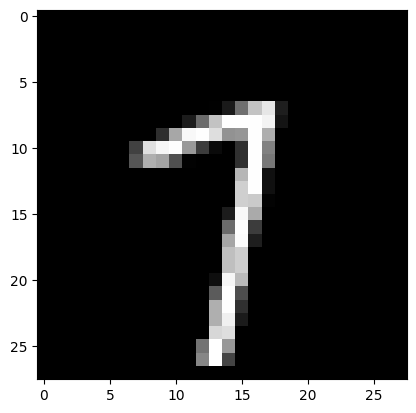

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

print(f'training inputs: shape {x_train.shape}, dtype {x_train.dtype}')
print(f'training outputs: shape {y_train.shape}, dtype {y_train.dtype}')
print(f'input range: {x_train.min(), x_train.max()}')
print(f'label range: {y_train.min(), y_train.max()}')

i_example = 42
x_train_example = x_train[i_example].reshape((28, 28))
y_train_example = y_train[i_example]
plt.imshow(x_train_example, cmap='gray')
print(f'label of training example {i_example}: {y_train_example}')

We need to convert the data into PyTorch tensors. For ease of use, tensors have some familiar attributes and methods.

In [5]:
x_train, y_train, x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))
print(f'training inputs: shape {x_train.shape}, dtype {x_train.dtype}')
print(f'training outputs: shape {y_train.shape}, dtype {y_train.dtype}')
print(f'input range: {x_train.min(), x_train.max()}')
print(f'label range: {y_train.min(), y_train.max()}')

training inputs: shape torch.Size([50000, 784]), dtype torch.float32
training outputs: shape torch.Size([50000]), dtype torch.int64
input range: (tensor(0.), tensor(0.9961))
label range: (tensor(0), tensor(9))


### Bare Metal MNIST
We will first train a model for classifying MNIST digits with nothing but tensor and gradient operations. We'll later substitute out chunks of this code with the appropriate PyTorch abstractions.

To keep things simple, for this we'll use a linear model. For a single example, the model is
$$ z = W^\top x + b $$
where $W \in \mathbb{R}^{784 \times 10}$ and $b \in \mathbb{R}^{10}$ are the parameters to be learned, $x \in [0, 1]^{784}$ is the MNIST image, and $z \in \mathbb{R}^{10}$ are the logits of the categorical distribution for the label of $x$.

To obtain categorical parameters from the logits, we do
$$ p = \text{softmax}(z) = \frac{1}{\sum_j \exp(z_j)} \exp(z).$$

The label $y \in \{0, \dots, 9\}$ implicitly defines a one-hot categorical parameter vector $y' \in \{0, 1\}^{10}$, where $y$ corresponds to the index of $y'$ that is 1. The negative log-likelihood is then
$$ \text{nll}(p, y) = - \sum_{i=0}^{9} y'_i \log(p_i) = -\log(p_y)$$

Note that our implementation will assume batched inputs with a batch size of $B$. That is,
$$x_b = \begin{bmatrix} x_1^\top \\ \vdots \\ x_B^\top \end{bmatrix} \in [0, 1]^{B \times 784}.$$ We can vectorize the above operations to process all $B$ inputs at once (naively using `for` loops is much, much slower). For example, to compute the logits, we have
$$z_b = x_b W + \begin{bmatrix} b^\top \\ \vdots \\ b^\top \end{bmatrix} \in \mathbb{R}^{B \times 10}$$

In [6]:
W = torch.randn(784, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)

def logits(x_b, W, b):
    return x_b @ W + b    # addition is broadcasted

def log_softmax(z_b):
    return z_b - torch.logsumexp(z_b, dim=1, keepdim=True)  # combining log and softmax is more numerically stable

def negative_log_likelihood(logp_b, y_b):
    return -torch.mean(logp_b[range(y_b.shape[0]), y_b])   # indexing trick

def accuracy(logit_b, y_b):
    return (logit_b.argmax(dim=1) == y_b).float().mean().item()

Note that the `requires_grad` keyword argument/attribute determines whether a tensor is a constant or a variable.

In [7]:
print(b.requires_grad)
print(y_train.requires_grad)

True
False


### Computation Graph
Now we have the opportunity to look at some of PyTorch's core mechanics: reverse-mode automatic differentiation (a.k.a. backpropagation) on a dynamic computation graph. Let's take a batch of training data and compute the average loss over the batch.

In [8]:
batch_size = 64
x_b, y_b = x_train[:batch_size], y_train[:batch_size]

def loss_fn(W, b, x_b, y_b):
    logit_b = logits(x_b, W, b)
    logp_b = log_softmax(logit_b)
    loss = negative_log_likelihood(logp_b, y_b)
    return loss

loss = loss_fn(W, b, x_b, y_b)

Computations like the above are automagically recorded on a computation graph. Let's take a peek.

In [9]:
!pip install torchviz

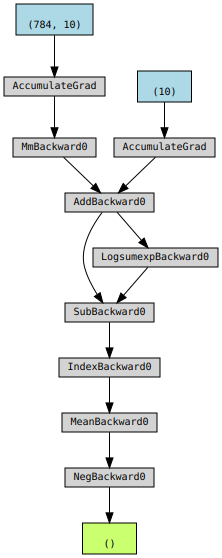

In [10]:
import torchviz
torchviz.make_dot(loss)

We can actually inspect tensors to see that each non-leaf variable tensor records its gradient function based on how it was obtained.

In [11]:
print(b.grad_fn)    # leaf variable
print(loss.grad_fn)
print(x_b.grad_fn)  # not a variable

None
None


### Using `autograd.grad` to Compute Gradients
We can now use reverse-mode automatic differentiation to compute the gradient of the loss with respect to our parameters!

In [12]:
from torch import autograd
loss = loss_fn(W, b, x_b, y_b)
W_grad, b_grad = autograd.grad(loss, inputs=(W, b))
print(b_grad)

tensor([ 0.2051, -0.1250,  0.1485, -0.0757, -0.1249,  0.0024, -0.0405,  0.0582,
        -0.0259, -0.0222])


We're now ready to optimize our linear MNIST model. Each iteration consists of the following steps:
* Sample a batch of training data.
* Compute the logits from the inputs using the model parameters.
* Compute a scalar loss from the logits and labels.
* Compute the gradient of the loss with respect to the parameters.
* Update the model parameters using the gradient.

Note that the last step is done in a context manager that disables the construction of the computation graph.

To check whether our optimization was successful, we'll look at the accuracy on the training data before and after.

In [13]:
lr = 0.5
num_epochs = 2

def train(W, b):
    print(f'accuracy before: {accuracy(logits(x_train, W, b), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = logits(x_b, W, b)
            logp_b = log_softmax(logit_b)
            loss = negative_log_likelihood(logp_b, y_b)
            W_grad, b_grad = autograd.grad(loss, inputs=(W, b))

            with torch.no_grad():   # we don't need gradients for this
                W -= lr * W_grad
                b -= lr * b_grad

    print(f'accuracy after: {accuracy(logits(x_train, W, b), y_train)}')

W = torch.randn(784, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)
train(W, b)

accuracy before: 0.10620000213384628
accuracy after: 0.8812599778175354


### Using `backward` to Compute Gradients
An alternative to using `autograd.grad` is to call `backward()` on the loss tensor. This _accumulates_ gradients of leaf tensors into their `grad` attribute. (Note that with this we don't need to specify the variables we're taking the gradient with respect to, nor do we obtain the gradients as output from the function call.)

When we're done using a gradient in a `grad` attribute, we should reset it to 0, else repeated accumulations may occur. We can do this with the `Tensor` method `zero_()`. (Note that the `_` signifies that the operation modifies the tensor in-place.)

In [14]:
print('before computing gradients')
print(b.grad)

loss = loss_fn(W, b, x_b, y_b)
loss.backward()
print('after forward pass and calling backward()')
print(b.grad)

loss = loss_fn(W, b, x_b, y_b)
loss.backward()
print('after another forward pass and calling backward() again')
print(b.grad)

b.grad.zero_()
print('after calling zero_()')
print(b.grad)

before computing gradients
None
after forward pass and calling backward()
tensor([-0.0010, -0.0039,  0.0037,  0.0023, -0.0114,  0.0132, -0.0002,  0.0235,
         0.0132, -0.0394])
after another forward pass and calling backward() again
tensor([-0.0019, -0.0078,  0.0073,  0.0046, -0.0227,  0.0263, -0.0005,  0.0470,
         0.0265, -0.0787])
after calling zero_()
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


When should you use `autograd.grad` vs. `backward`? In general, `backward` is more convenient, but there are times (e.g. in Homework 2) when you need more fine-grained control over gradient computation. Let's see what the training code looks like when we use `backward`:

In [15]:
def train(W, b):
    print(f'accuracy before: {accuracy(logits(x_train, W, b), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = logits(x_b, W, b)
            logp_b = log_softmax(logit_b)
            loss = negative_log_likelihood(logp_b, y_b)
            loss.backward()

            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_()
                b.grad.zero_()

    print(f'accuracy after: {accuracy(logits(x_train, W, b), y_train)}')

W = torch.randn(784, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)
train(W, b)

accuracy before: 0.07010000199079514
accuracy after: 0.8821200132369995


### `nn.functional`
Now, let's refactor and extend our training code by allowing ourselves to use other `torch` modules. We'll first look at `torch.nn`.

`nn.functional` (commonly abbreviated as just `F`) includes many useful functions, e.g. loss functions and activation functions. In particular, `F.cross_entropy` combines the `log_softmax` and `negative_log_likelihood` functions into one.

If you're used to using TensorFlow's [CategoricalCrossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy), note that `F.cross_entropy` takes integer labels, not one-hot labels

In [16]:
import torch.nn as nn
import torch.nn.functional as F

with torch.no_grad():
    logit_b = logits(x_b, W, b)
    print(negative_log_likelihood(log_softmax(logit_b), y_b))
    print(F.cross_entropy(logit_b, y_b))

tensor(0.1862)
tensor(0.1862)


### `nn.Module`
`nn.Module` is a useful class that corresponds loosely to an intuitive notion of a parameterized model. It
* registers `nn.Parameter`s, which are essentially variable tensors, as attributes
* holds as the `forward` method the model's forward pass

In [17]:
class MNISTLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.randn(784, 10))
        self.b = nn.Parameter(torch.randn(10))

    def forward(self, x_b):
        return x_b @ self.W + self.b

Using the `nn.Module` can be very convenient. For example, previously we had to manually zero the `grad` attribute of `W` and `b`. We can now use the `parameters` method, which returns an iterator over module parameters, and the `zero_grad` method, which zeros the `grad` attribute of every module parameter.

After substituting code for the model forward pass, the loss computation, the optimization step, and the gradient zeroing, the training code now looks like this:

In [18]:
def train(model):
    print(f'accuracy before: {accuracy(model(x_train), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = model(x_b)    # an nn.Module is callable
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train), y_train)}')

train(MNISTLinear())

accuracy before: 0.07667999714612961
accuracy after: 0.8832799792289734


`nn` contains many `nn.Module` subclasses that correspond to commonly used chunks of computation. One such "layer" is the linear model we've been using! We can replace our `MNISTLinear` class with an `nn.Linear`.

In [19]:
train(nn.Linear(784, 10))

accuracy before: 0.06741999834775925
accuracy after: 0.9120399951934814


Our optimization went differently in 2 epochs this time around. This is probably because the parameters in `nn.Linear` are [initialized slightly differently](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). It's always important to read documentation!

### MNIST MLP
What if we want to use a two-layer fully-connected network? `nn.Module`s can register `nn.Module` attributes!

In [20]:
class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 64)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(64, 10)

    def forward(self, x_b):
        return self.linear2(self.activation(self.linear1(x_b)))

train(MNISTMLP())

accuracy before: 0.12398000061511993
accuracy after: 0.9607599973678589


##Saving/Loading pre-trained weights
Sometimes multiple people may have to use the same network. It can take a lot of time for everyone to train their network from scratch. It is environmentally also disastrous as the carbon footprint of training large networks is very huge.

It would be better if we could train and save weights for our network, and reuse them later if we need to. PyTorch gives us ways to do this easily!

In [21]:
network = MNISTMLP()
train(network)

torch.save(network.state_dict(), "network.pt")

accuracy before: 0.07614000141620636
accuracy after: 0.953819990158081


The above code saves the network's weights to the given path, in this case "network.pt". Now we will show that loading the model's weight without retraining it from scratch retrieves prior performance.

In [22]:
network = MNISTMLP()
print(f'accuracy of initialized network: {accuracy(network(x_train), y_train)}')

network.load_state_dict(torch.load("network.pt"))
print(f'accuracy after loading weights: {accuracy(network(x_train), y_train)}')

accuracy of initialized network: 0.1163799986243248
accuracy after loading weights: 0.953819990158081


<ipython-input-22-2d02430dcb42>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load("network.pt"))


### Are You Registered?
`nn.Module`s [have some specific rules](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) regarding what attributes are properly registered (i.e. identified as part of the model). We've seen that `nn.Parameter`s and `nn.Module`s are, but most Python objects are not. For example, you might consider it cleaner to implement the `MNISTMLP` this way:

In [23]:
class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        ]

    def forward(self, x_b):
        for layer in self.layers:
            x_b = layer(x_b)
        return x_b

train(MNISTMLP())
print(list(MNISTMLP().parameters()))

accuracy before: 0.07054000347852707
accuracy after: 0.07054000347852707
[]


Uh oh! Even though the `layers` list has `nn.Module`s, it itself wasn't recognized as a registerable attribute. To get around this, we have the `nn.ModuleList`:

In [24]:
class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        ])

    def forward(self, x_b):
        for layer in self.layers:
            x_b = layer(x_b)
        return x_b

train(MNISTMLP())

accuracy before: 0.10694000124931335
accuracy after: 0.9515399932861328


### `nn.Sequential`
It's pretty common to have a sequence of layers we want to iteratively apply onto an input. We can replace the `for` loop business in the forward pass by using an `nn.Sequential` container, a very commonly used abstraction:

In [25]:
train(nn.Sequential(
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
))

accuracy before: 0.07383999973535538
accuracy after: 0.9613400101661682


### `torch.optim`
`torch.optim` contains implementations of many common optimization algorithms. When initializing an optimizer instance, we need to pass in the model parameters. Now, instead of manually coding the update rule, we call the optimizer's `step` method. The optimizer can also handle resetting parameter gradients.

In [26]:
from torch import optim

def train(model):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'accuracy before: {accuracy(model(x_train), y_train)}')

    for i_epoch in range(num_epochs):
        i_batch_start = 0
        while i_batch_start + batch_size < x_train.shape[0]:
            x_b = x_train[i_batch_start:i_batch_start + batch_size]
            y_b = y_train[i_batch_start:i_batch_start + batch_size]
            i_batch_start += batch_size

            logit_b = model(x_b)
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train), y_train)}')

train(MNISTMLP())

accuracy before: 0.09752000123262405
accuracy after: 0.9586799740791321


### `torch.utils.data`
Notice how we are manually slicing the `x_train` and `y_train` tensors to get batches. There's a more convenient way to do this:
`torch.utils.data` features the `Dataset`, `Sampler`, and `DataLoader` abstractions, which are useful for transforming, sampling, and iterating over data. Let's implement a custom `Dataset` subclass for MNIST which we can then use to instantiate a `DataLoader`:

In [27]:
from torch.utils import data

class MNISTDataset(data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset_train = MNISTDataset(x_train, y_train)
dataloader_train = data.DataLoader(dataset_train, batch_size=batch_size)

def train(model):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'accuracy before: {accuracy(model(x_train), y_train)}')

    for i_epoch in range(num_epochs):
        for x_b, y_b in dataloader_train:   # dataloaders are iterators
            logit_b = model(x_b)
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train), y_train)}')

train(MNISTMLP())

accuracy before: 0.09415999799966812
accuracy after: 0.9545800089836121


### Using a GPU
Now, let's see how to use a GPU in PyTorch. Every tensor has a `device` attribute (default: `'cpu'`). GPU-accelerated computation requires the involved tensors to all be on device `'cuda'`. The `to` method is a handy way to move tensors around.



In [28]:
x = torch.tensor(1.)
print(x.device)
x = x.to('cuda')
print(x.device)

cpu
cuda:0


The `nn.Module` also has a `to` method that transfers all parameters (and buffer items) to a specified device.

In [29]:
from torch.utils import data

dataset_train = data.TensorDataset(x_train, y_train)
dataloader_train = data.DataLoader(dataset_train, batch_size=batch_size)

def train(model):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'accuracy before: {accuracy(model(x_train.to("cuda")), y_train.to("cuda"))}')

    for i_epoch in range(num_epochs):
        for x_b, y_b in dataloader_train:
            x_b, y_b = x_b.to('cuda'), y_b.to('cuda')
            logit_b = model(x_b)
            loss = F.cross_entropy(logit_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print(f'accuracy after: {accuracy(model(x_train.to("cuda")), y_train.to("cuda"))}')

train(MNISTMLP().to('cuda'))

accuracy before: 0.11267999559640884
accuracy after: 0.9650399684906006


### Clean-up
To wrap this section up, we'll refactor our code to facilitate assessing on both train and val data with data-loading, and using the GPU.

In [30]:
dataset_val = data.TensorDataset(x_val, y_val)
dataloader_val = data.DataLoader(dataset_val, batch_size=batch_size)

def loss_fn(model, x_b, y_b):
    logit_b = model(x_b)
    loss = F.cross_entropy(logit_b, y_b)
    return loss, y_b.shape[0]

def accuracy(model, x_b, y_b):
    logit_b = model(x_b)
    accuracy = (logit_b.argmax(dim=1) == y_b).float().mean()
    return accuracy, y_b.shape[0]

def assess(model, dataloader):
    loss_total_r, correct_r, n_r = 0, 0, 0
    with torch.no_grad():
        for x_b, y_b in dataloader:
            x_b, y_b = x_b.to('cuda'), y_b.to('cuda')
            loss, n = loss_fn(model, x_b, y_b)
            acc, n = accuracy(model, x_b, y_b)
            loss_total_r += loss * n
            correct_r += acc * n
            n_r += n
    loss_total_r, correct_r = loss_total_r.item(), correct_r.item()
    return loss_total_r / n_r, correct_r / n_r

def train(model, optimizer):
    print('before')
    print(f'train loss and acc: {assess(model, dataloader_train)}')
    print(f'val loss and acc: {assess(model, dataloader_val)}')

    for i_epoch in range(num_epochs):
        for x_b, y_b in dataloader_train:
            x_b, y_b = x_b.to('cuda'), y_b.to('cuda')
            loss, _ = loss_fn(model, x_b, y_b)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    print('after')
    print(f'train loss and acc: {assess(model, dataloader_train)}')
    print(f'val loss and acc: {assess(model, dataloader_val)}')

model = MNISTMLP().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr)
train(model, optimizer)

before
train loss and acc: (2.3162325, 0.07892)
val loss and acc: (2.315925, 0.0786)
after
train loss and acc: (0.150307724609375, 0.95222)
val loss and acc: (0.1640982666015625, 0.9514)


# More PyTorch Features: A Whirlwind Tour

### MNIST CNN
2D convolutional layers expect an input of shape $(B, C, H, W)$ or `(batch, channels, height, width)`. For a batch of MNIST images, this is $(B, 1, 28, 28)$.

In [31]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(800, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )

    def forward(self, x_b):
        return self.layers(x_b.view((-1, 1, 28, 28)))

model = MNISTCNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer)

before
train loss and acc: (2.3030059375, 0.0961)
val loss and acc: (2.30335703125, 0.0883)
after
train loss and acc: (0.03881703369140625, 0.9874)
val loss and acc: (0.056931982421875, 0.9844)


# Transformer and TorchText: Sequence-to-Sequence Modeling 
This is a tutorial on how to train a sequence-to-sequence model that uses the nn.Transformer module.

PyTorch 1.2 release includes a standard transformer module based on the paper Attention is All You Need. The transformer model has been proved to be superior in quality for many sequence-to-sequence problems while being more parallelizable. The nn.Transformer module relies entirely on an attention mechanism (another module recently implemented as nn.MultiheadAttention) to draw global dependencies between input and output. The nn.Transformer module is now highly modularized such that a single component (like nn.TransformerEncoder in this tutorial) can be easily adapted/composed

## Define the model


In this tutorial, we train nn.TransformerEncoder model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). The nn.TransformerEncoder consists of multiple layers of nn.TransformerEncoderLayer. Along with the input sequence, a square attention mask is required because the self-attention layers in nn.TransformerEncoder are only allowed to attend the earlier positions in the sequence. For the language modeling task, any tokens on the future positions should be masked. To have the actual words, the output of nn.TransformerEncoder model is sent to the final Linear layer, which is followed by a log-Softmax function.

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

PositionalEncoding module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Load and batch data
The training process uses Wikitext-2 dataset from torchtext. The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. Starting from sequential data, the batchify() function arranges the dataset into columns, trimming off any tokens remaining after the data has been divided into batches of size batch_size. For instance, with the alphabet as the sequence (total length of 26) and a batch size of 4, we would divide the alphabet into 4 sequences of length 6:

These columns are treated as independent by the model, which means that the dependence of G and F can not be learned, but allows more efficient batch processing.

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

Out: 

downloading wikitext-2-v1.zip
extracting

# Functions to generate input and target sequence
get_batch() function generates the input and target sequence for the transformer model. It subdivides the source data into chunks of length bptt. For the language modeling task, the model needs the following words as Target. For example, with a bptt value of 2, we’d get the following two Variables for i = 0:

It should be noted that the chunks are along dimension 0, consistent with the S dimension in the Transformer model. The batch dimension N is along dimension 1.


In [ ]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

## Initiate an instance
The model is set up with the hyperparameter below. The vocab size is equal to the length of the vocab object.

In [ ]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

## Run the model

CrossEntropyLoss is applied to track the loss and SGD implements stochastic gradient descent method as the optimizer. The initial learning rate is set to 5.0. StepLR is applied to adjust the learn rate through epochs. During the training, we use nn.utils.clip_grad_norm_ function to scale all the gradient together to prevent exploding.

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

In [ ]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

Out:

| epoch   1 |   200/ 2981 batches | lr 5.00 | ms/batch 29.39 | loss  8.05 | ppl  3123.83
| epoch   1 |   400/ 2981 batches | lr 5.00 | ms/batch 28.52 | loss  6.74 | ppl   844.07
| epoch   1 |   600/ 2981 batches | lr 5.00 | ms/batch 28.50 | loss  6.35 | ppl   571.65
| epoch   1 |   800/ 2981 batches | lr 5.00 | ms/batch 28.60 | loss  6.22 | ppl   505.09
| epoch   1 |  1000/ 2981 batches | lr 5.00 | ms/batch 28.60 | loss  6.11 | ppl   451.99
| epoch   1 |  1200/ 2981 batches | lr 5.00 | ms/batch 28.57 | loss  6.08 | ppl   439.11
| epoch   1 |  1400/ 2981 batches | lr 5.00 | ms/batch 28.60 | loss  6.04 | ppl   419.65
| epoch   1 |  1600/ 2981 batches | lr 5.00 | ms/batch 28.53 | loss  6.05 | ppl   426.08
| epoch   1 |  1800/ 2981 batches | lr 5.00 | ms/batch 28.60 | loss  5.96 | ppl   387.40
| epoch   1 |  2000/ 2981 batches | lr 5.00 | ms/batch 28.61 | loss  5.96 | ppl   387.10
| epoch   1 |  2200/ 2981 batches | lr 5.00 | ms/batch 28.61 | loss  5.85 | ppl   346.65
| epoch   1 |  2400/ 2981 batches | lr 5.00 | ms/batch 28.59 | loss  5.90 | ppl   363.66
| epoch   1 |  2600/ 2981 batches | lr 5.00 | ms/batch 28.58 | loss  5.89 | ppl   362.43
| epoch   1 |  2800/ 2981 batches | lr 5.00 | ms/batch 28.63 | loss  5.79 | ppl   327.16
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 88.73s | valid loss  5.69 | valid ppl   297.35
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 2981 batches | lr 4.51 | ms/batch 28.74 | loss  5.79 | ppl   328.47
| epoch   2 |   400/ 2981 batches | lr 4.51 | ms/batch 28.63 | loss  5.77 | ppl   320.22
| epoch   2 |   600/ 2981 batches | lr 4.51 | ms/batch 28.60 | loss  5.60 | ppl   270.08
| epoch   2 |   800/ 2981 batches | lr 4.51 | ms/batch 28.58 | loss  5.64 | ppl   280.65
| epoch   2 |  1000/ 2981 batches | lr 4.51 | ms/batch 28.61 | loss  5.59 | ppl   267.77
| epoch   2 |  1200/ 2981 batches | lr 4.51 | ms/batch 28.51 | loss  5.61 | ppl   272.92
| epoch   2 |  1400/ 2981 batches | lr 4.51 | ms/batch 28.58 | loss  5.62 | ppl   276.17
| epoch   2 |  1600/ 2981 batches | lr 4.51 | ms/batch 28.52 | loss  5.66 | ppl   286.68
| epoch   2 |  1800/ 2981 batches | lr 4.51 | ms/batch 28.62 | loss  5.59 | ppl   267.02
| epoch   2 |  2000/ 2981 batches | lr 4.51 | ms/batch 28.65 | loss  5.61 | ppl   272.22
| epoch   2 |  2200/ 2981 batches | lr 4.51 | ms/batch 28.60 | loss  5.51 | ppl   247.40
| epoch   2 |  2400/ 2981 batches | lr 4.51 | ms/batch 28.55 | loss  5.57 | ppl   263.63
| epoch   2 |  2600/ 2981 batches | lr 4.51 | ms/batch 28.55 | loss  5.59 | ppl   268.08
| epoch   2 |  2800/ 2981 batches | lr 4.51 | ms/batch 28.63 | loss  5.51 | ppl   247.61
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 88.63s | valid loss  5.56 | valid ppl   259.39
-----------------------------------------------------------------------------------------
| epoch   3 |   200/ 2981 batches | lr 4.29 | ms/batch 28.74 | loss  5.55 | ppl   257.69
| epoch   3 |   400/ 2981 batches | lr 4.29 | ms/batch 28.56 | loss  5.55 | ppl   256.46
| epoch   3 |   600/ 2981 batches | lr 4.29 | ms/batch 28.60 | loss  5.35 | ppl   211.22
| epoch   3 |   800/ 2981 batches | lr 4.29 | ms/batch 28.58 | loss  5.42 | ppl   226.08
| epoch   3 |  1000/ 2981 batches | lr 4.29 | ms/batch 28.62 | loss  5.38 | ppl   216.52
| epoch   3 |  1200/ 2981 batches | lr 4.29 | ms/batch 28.59 | loss  5.41 | ppl   223.14
| epoch   3 |  1400/ 2981 batches | lr 4.29 | ms/batch 28.62 | loss  5.43 | ppl   228.66
| epoch   3 |  1600/ 2981 batches | lr 4.29 | ms/batch 28.64 | loss  5.47 | ppl   238.30
| epoch   3 |  1800/ 2981 batches | lr 4.29 | ms/batch 28.48 | loss  5.40 | ppl   221.59
| epoch   3 |  2000/ 2981 batches | lr 4.29 | ms/batch 28.62 | loss  5.44 | ppl   230.29
| epoch   3 |  2200/ 2981 batches | lr 4.29 | ms/batch 28.60 | loss  5.32 | ppl   205.12
| epoch   3 |  2400/ 2981 batches | lr 4.29 | ms/batch 28.58 | loss  5.39 | ppl   219.94
| epoch   3 |  2600/ 2981 batches | lr 4.29 | ms/batch 28.66 | loss  5.41 | ppl   224.03
| epoch   3 |  2800/ 2981 batches | lr 4.29 | ms/batch 28.59 | loss  5.34 | ppl   208.79
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 88.64s | valid loss  5.55 | valid ppl   257.39
-----------------------------------------------------------------------------------------

## Evaluate the model with the test dataset
Apply the best model to check the result with the test dataset

In [ ]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

Out:

=========================================================================================
| End of training | test loss  5.46 | test ppl   235.14
=========================================================================================

### MNIST LSTM
When constructed using the `batch_first=True` argument, `nn.LSTM`s expect inputs of shape $(B, L, D)$ or `(batch, sequence length, element size)`. We'll interpret the rows of the MNIST image as sequence elements, and compute the logits from the last LSTM output (i.e. wait for the LSTM to see the entire image).

In [32]:
class MNISTLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.LSTM = nn.LSTM(input_size=28, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 10)

    def forward(self, x_b):
        out, _ = self.LSTM(x_b.view((-1, 28, 28)))  # out contains outputs at each iteration over the sequence
        return self.linear(out[:, -1, :])   # only the out at the last iteration has seen the entire image

model = MNISTLSTM().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer)

before
train loss and acc: (2.30728546875, 0.09976)
val loss and acc: (2.30689140625, 0.0961)
after
train loss and acc: (0.17556994140625, 0.95036)
val loss and acc: (0.164346044921875, 0.9524)


### `nn.Embedding`
Oftentimes we will have categorical data with too many categories to comfortably convert into one-hot encodings. Examples of this include tokens in NLP and $(x,y)$ positions on a grid. One common way to process this data is to use an `nn.Embedding`, or a table of dense vectors that can be indexed by the categorical data. The dense vectors can be optimized. `nn.Embedding` supports advanced indexing.

In [33]:
embedding = nn.Embedding(num_embeddings=1000, embedding_dim=64)
print(embedding(torch.tensor(42)).shape)
print(embedding(torch.tensor(42)).requires_grad)
indices = torch.tensor([
    [0, 1, 42, 999],
    [1, 1, 2, 3]
])
print(indices.shape)
print(embedding(indices).shape)

torch.Size([64])
True
torch.Size([2, 4])
torch.Size([2, 4, 64])


If you're interested in NLP, a nice use of `nn.Embedding` and recurrent layers (`nn.GRU`) for natural language translation can be found in [this tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

### `torch.distributions`
Aside from conveniently providing commonly used methods (e.g. density/mass evaluation), one of the main features of this module is the use of the reparameterization trick to facilitate backpropagation through random samples to the underlying distribution parameters (and beyond).

In [34]:
from torch import distributions
loc = torch.tensor(0., requires_grad=True)
scale = torch.tensor(1., requires_grad=True)
p = distributions.Normal(loc, scale)
x = p.rsample(torch.Size([5]))
print(x)    # grad_fn comes from reparameterization trick
y = -torch.mean(x**2)
y.backward()
print(scale.grad)

tensor([ 0.3411,  0.0985, -0.5268,  0.2175, -2.2333], grad_fn=<AddBackward0>)
tensor(-2.1754)


If we don't use `rsample`, we can't take gradients through the sampling step.

In [38]:
x = p.rsample(torch.Size([5]))
print(x)
y = -torch.sum(x**2)
y.backward()

tensor([-0.3452, -1.1077, -0.3113, -2.0162,  0.3057], grad_fn=<AddBackward0>)


# Debugging, Documentation, and Getting Help
Your assignments won't be in Jupyter notebooks, but in Python scripts. This means you won't have the interactivity of cell-based execution, but to the rescue comes `pdb`, the Python Debugger. Use it to

*   set breakpoints in the code to interactively inspect program elements: `import pdb; pdb.set_trace()`
*   automatically start a debugging session when an exception is thrown: `python -m pdb -c continue main.py`

Both will be super, super useful.

When something about PyTorch is confusing you, the first place to look is the [PyTorch documentation](https://https://pytorch.org/docs/stable/index.html). (The author of this tutorial consulted the documentation no fewer than 20 times when making it.) This is often the last place you need to look, but sometimes the [PyTorch forums](https://https://discuss.pytorch.org/) can be helpful, too. (Use the search tool!) And of course, you're always welcome to post on Ed or seek out one of your friendly neighborhood CAs.





---

